In [101]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import scipy
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

## Import labeled dataset

In [88]:
#Import the dataset
data_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/archive/all-data.csv'
df = pd.read_csv(data_path, 
                   encoding='unicode_escape',
                   names=['Sentiment', 'Text'])

In [89]:
df = df.rename(columns={'Text' : 'text' , 'Sentiment' : 'sentiment'})

In [90]:
df["text"]=df["text"].str.lower() #We convert our texts to lowercase.
df["text"]=df["text"].str.replace("[^\w\s]","") #We remove punctuation marks from our texts.

In [91]:
#Perform data exploration on the dataset
print(df.head())

  sentiment                                               text
0   neutral  according to gran , the company has no plans t...
1   neutral  technopolis plans to develop in stages an area...
2  negative  the international electronic industry company ...
3  positive  with the new production plant the company woul...
4  positive  according to the company 's updated strategy f...


<function matplotlib.pyplot.show(close=None, block=None)>

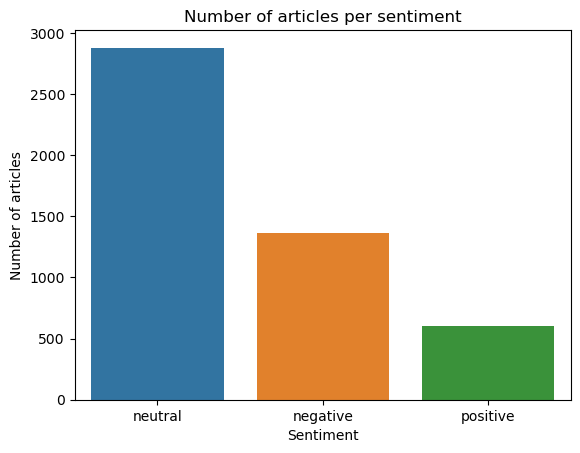

In [92]:
ax = sns.barplot(x= df.sentiment.unique(), y=df.sentiment.value_counts())
ax.set(xlabel='Sentiment', ylabel='Number of articles' , title='Number of articles per sentiment')
plt.show

The dataset is relatively imbalanced with a high proportion of neutral comments

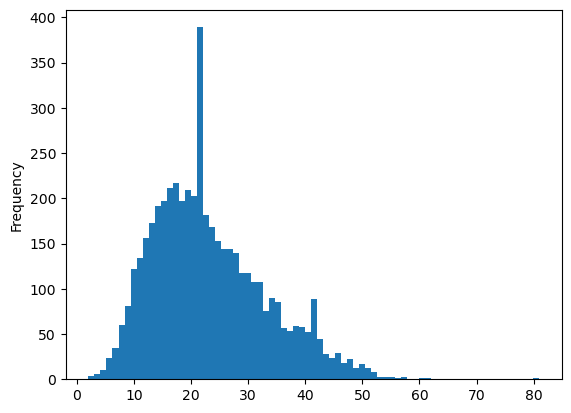

In [93]:
#Plot the distribution of the number of words per article
df['text'].apply(lambda x: len(x.split(" "))).mean()
df['text'].apply(lambda x: len(x.split(" "))).plot(kind='hist' , bins=  75)
plt.show()

We have no empty articles and the distribution of the length is relatively well balanced among articles

In [94]:
#We map the sentiment to a numerical value positive : 1, neutral 0 and negative 2
df['sentiment'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': 2})

# Benchmark models

## Benchmark model : Bag of words

In [95]:
# Splitting the data into training and testing sets
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

# Convert text data into a bag-of-words model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train_bow)
X_test_bow = vectorizer.transform(X_test_bow)

In [96]:
def svm_classifier (X_train, y_train, X_test):
    # Train the model
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)

    # Predict the sentiment for the test data
    y_pred = svm.predict(X_test)

    return y_pred

In [97]:
def gradient_boosting_classifier (X_train, y_train, X_test):
    # Train a Gradient Boosting classifier
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = xgb_clf.predict(X_test)

    return y_pred

In [98]:
def naive_bayes_classifier (X_train, y_train, X_test):
    # Train a Naive Bayes classifier
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = nb_clf.predict(X_test)
    # Evaluate using accuracy, precision, recall, F1-score as before

    return y_pred

In [104]:
def mlp_classifier(X_train, y_train, X_test):
    # Convert sparse matrix to dense
    X_train_dense = X_train.todense()
    X_test_dense = X_test.todense()

    # Convert labels to one-hot encoding
    y_train_cat = to_categorical(y_train)
    
    # Define and compile the MLP model
    model = Sequential()
    model.add(Dense(512, input_shape=(X_train_dense.shape[1],), activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_dense, y_train_cat, batch_size=128, epochs=10)

    # Predict
    y_pred = model.predict(X_test_dense)
    # Convert predictions to labels if necessary
    y_pred_labels = np.argmax(y_pred, axis=1)
    return y_pred_labels
        

In [125]:
def logistic_regression_classifier(X_train, y_train, X_test):
    # Train a logistic regression classifier
    lr_clf = LogisticRegression(max_iter=1000)
    lr_clf.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = lr_clf.predict(X_test)

    return y_pred

In [108]:
#Classification using bag of words
y_pred_svm_bow = svm_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_xgb_bow  = gradient_boosting_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_nb_bow  = naive_bayes_classifier(X_train_bow, y_train_bow, X_test_bow)
y_pred_mlp_bow  = mlp_classifier(X_train_bow, y_train_bow, X_test_bow)


Epoch 1/10
31/31 [==============================] - 3s 73ms/step - loss: 0.8426 - accuracy: 0.6370
Epoch 2/10
31/31 [==============================] - 2s 66ms/step - loss: 0.3747 - accuracy: 0.8643
Epoch 3/10
31/31 [==============================] - 2s 75ms/step - loss: 0.0878 - accuracy: 0.9755
Epoch 4/10
31/31 [==============================] - 2s 64ms/step - loss: 0.0292 - accuracy: 0.9936
Epoch 5/10
31/31 [==============================] - 2s 74ms/step - loss: 0.0185 - accuracy: 0.9951
Epoch 6/10
31/31 [==============================] - 2s 69ms/step - loss: 0.0132 - accuracy: 0.9966
Epoch 7/10
31/31 [==============================] - 2s 70ms/step - loss: 0.0123 - accuracy: 0.9974
Epoch 8/10
31/31 [==============================] - 2s 69ms/step - loss: 0.0130 - accuracy: 0.9974
Epoch 9/10
31/31 [==============================] - 2s 74ms/step - loss: 0.0097 - accuracy: 0.9982
Epoch 10/10
31/31 [==============================] - 0s 5ms/step


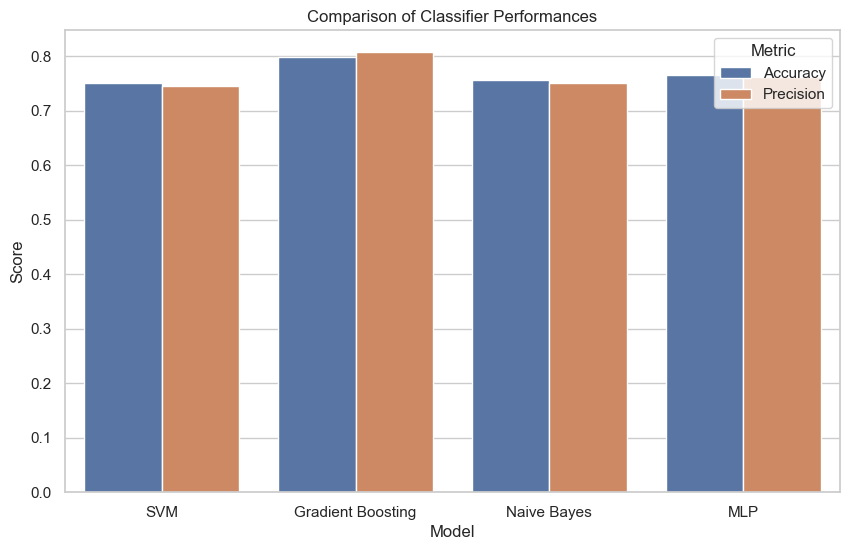

In [109]:
metrics = {
    'Model': ['SVM', 'Gradient Boosting', 'Naive Bayes', 'MLP'],
    'Accuracy': [
        accuracy_score(y_test_bow, y_pred_svm_bow),
        accuracy_score(y_test_bow, y_pred_xgb_bow),
        accuracy_score(y_test_bow, y_pred_nb_bow),
        accuracy_score(y_test_bow, y_pred_mlp_bow)
    ],
    'Precision': [
        precision_score(y_test_bow, y_pred_svm_bow, average='weighted'),
        precision_score(y_test_bow, y_pred_xgb_bow, average='weighted'),
        precision_score(y_test_bow, y_pred_nb_bow, average='weighted'),
        precision_score(y_test_bow, y_pred_mlp_bow, average='weighted')
    ],
    # Add Recall and F1-Score similarly
}

df_metrics = pd.DataFrame(metrics)
df_melted = pd.melt(df_metrics, id_vars='Model', var_name='Metric', value_name='Value')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.title('Comparison of Classifier Performances')
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)
plt.ylabel('Score')
plt.show()


### Benchmark model : TF-IDF (Term Frequency-Inverse Frequency)

In [110]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)

# Only transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)

In [111]:
#Classification using bag of words
y_pred_svm_tfidf = svm_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_xgb_tfidf  = gradient_boosting_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_nb_tfidf  = naive_bayes_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)
y_pred_mlp_tfidf = mlp_classifier(X_train_tfidf, y_train_tfidf, X_test_tfidf)

Epoch 1/10
31/31 [==============================] - 3s 73ms/step - loss: 0.8948 - accuracy: 0.5978
Epoch 2/10
31/31 [==============================] - 2s 66ms/step - loss: 0.5067 - accuracy: 0.7732
Epoch 3/10
31/31 [==============================] - 2s 65ms/step - loss: 0.1677 - accuracy: 0.9613
Epoch 4/10
31/31 [==============================] - 2s 61ms/step - loss: 0.0440 - accuracy: 0.9902
Epoch 5/10
31/31 [==============================] - 2s 63ms/step - loss: 0.0250 - accuracy: 0.9946
Epoch 6/10
31/31 [==============================] - 2s 64ms/step - loss: 0.0172 - accuracy: 0.9961
Epoch 7/10
31/31 [==============================] - 2s 64ms/step - loss: 0.0096 - accuracy: 0.9969
Epoch 8/10
31/31 [==============================] - 2s 61ms/step - loss: 0.0079 - accuracy: 0.9982
Epoch 9/10
31/31 [==============================] - 2s 61ms/step - loss: 0.0077 - accuracy: 0.9977
Epoch 10/10
31/31 [==============================] - 0s 4ms/step


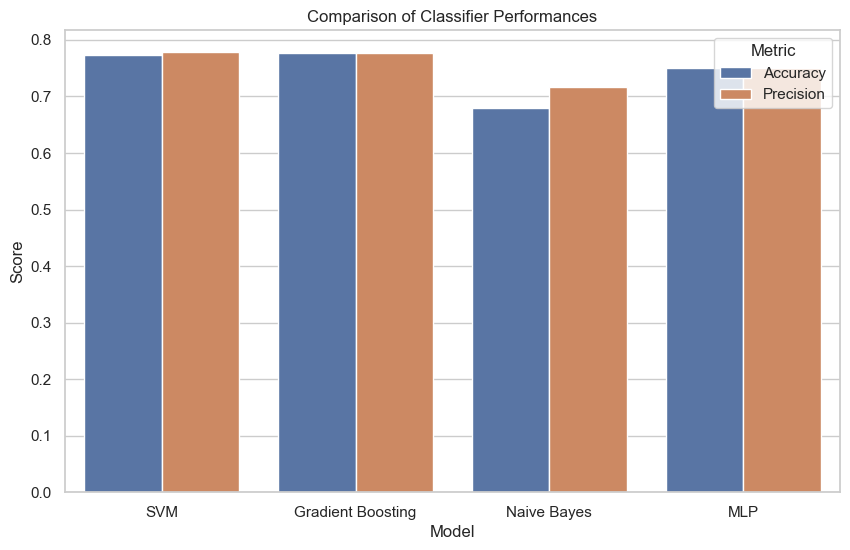

In [129]:
metrics_tfidf = {
    'Model': ['SVM', 'Gradient Boosting', 'Naive Bayes', 'MLP'],
    'Accuracy': [
        accuracy_score(y_test_tfidf, y_pred_svm_tfidf),
        accuracy_score(y_test_tfidf, y_pred_xgb_tfidf),
        accuracy_score(y_test_tfidf, y_pred_nb_tfidf),
        accuracy_score(y_test_tfidf, y_pred_mlp_tfidf)
    ],
    'Precision': [
        precision_score(y_test_tfidf, y_pred_svm_tfidf, average='weighted'),
        precision_score(y_test_tfidf, y_pred_xgb_tfidf, average='weighted'),
        precision_score(y_test_tfidf, y_pred_nb_tfidf, average='weighted'),
        precision_score(y_test_tfidf, y_pred_mlp_tfidf, average='weighted')
    ],
    # Add Recall and F1-Score similarly
}

df_metrics_tfidf = pd.DataFrame(metrics_tfidf)
df_melted_tfidf = pd.melt(df_metrics_tfidf, id_vars='Model', var_name='Metric', value_name='Value')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.title('Comparison of Classifier Performances')
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted_tfidf)
plt.ylabel('Score')
plt.show()

### Benchmark model : GloVe

In [114]:
def load_glove_model(glove_file_path):
    print("Loading Glove Model")
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        glove_model = {}
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
        print(f"{len(glove_model)} words loaded!")
        return glove_model

glove_path = '/Users/romainberquet/Desktop/epfl/ml-fin/Projet/glove.6B/glove.6B.300d.txt'  
glove_model = load_glove_model(glove_path)

X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

Loading Glove Model
400000 words loaded!


In [117]:
def document_vector(glove_model, doc):
    words = doc.split()
    word_vectors = [glove_model[word] for word in words if word in glove_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)  # 300 is the GloVe vector size

X_train_vectors_glove = np.array([document_vector(glove_model, text) for text in X_train_glove])
X_test_vectors_glove = np.array([document_vector(glove_model, text) for text in X_test_glove])

In [126]:
#Classification using bag of words
y_pred_svm_Glove = svm_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)
y_pred_xgb_Glove  = gradient_boosting_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)

#Add a logistic regression classifier
y_pred_lr_Glove = logistic_regression_classifier(X_train_vectors_glove, y_train_glove, X_test_vectors_glove)

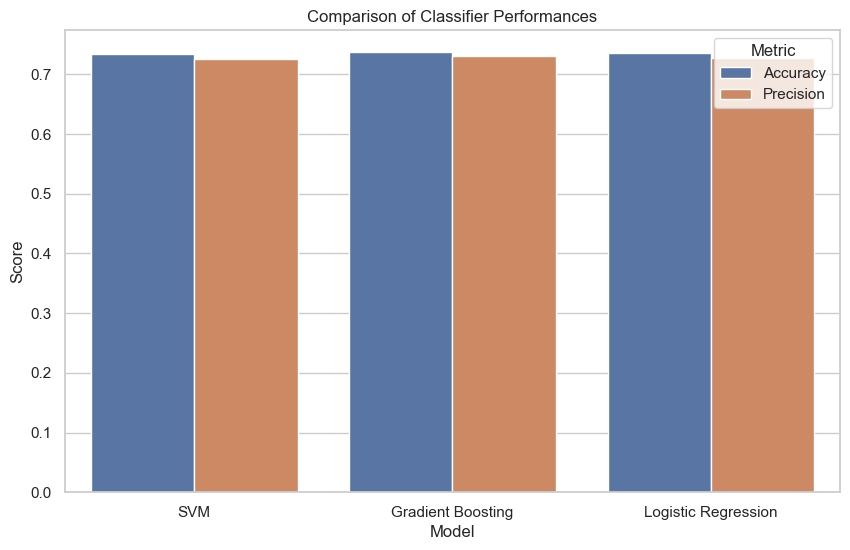

In [131]:
metrics_glove = {
    'Model': ['SVM', 'Gradient Boosting', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test_glove, y_pred_svm_Glove),
        accuracy_score(y_test_glove, y_pred_xgb_Glove),
        accuracy_score(y_test_glove, y_pred_lr_Glove),
    ],
    'Precision': [
        precision_score(y_test_glove, y_pred_svm_Glove, average='weighted'),
        precision_score(y_test_glove, y_pred_xgb_Glove, average='weighted'),
        precision_score(y_test_glove, y_pred_lr_Glove, average='weighted'),
    ],
    # Add Recall and F1-Score similarly
}

df_metrics_glove = pd.DataFrame(metrics_glove)
df_melted_glove = pd.melt(df_metrics_glove, id_vars='Model', var_name='Metric', value_name='Value')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.title('Comparison of Classifier Performances')
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted_glove)
plt.ylabel('Score')
plt.show()

### Financial BERT

In [44]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [45]:
X = df['text'].to_list()
y = df['sentiment'].to_list()

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [48]:
classification_report_finbert = classification_report(y, preds)

metrics_finbert = {
    'accuracy': accuracy_score(y, preds),
    'precision': precision_score(y, preds, average='weighted'),
    'recall': recall_score(y, preds, average='weighted'),
    'f1': f1_score(y, preds, average='weighted')
}

# Models comparaison

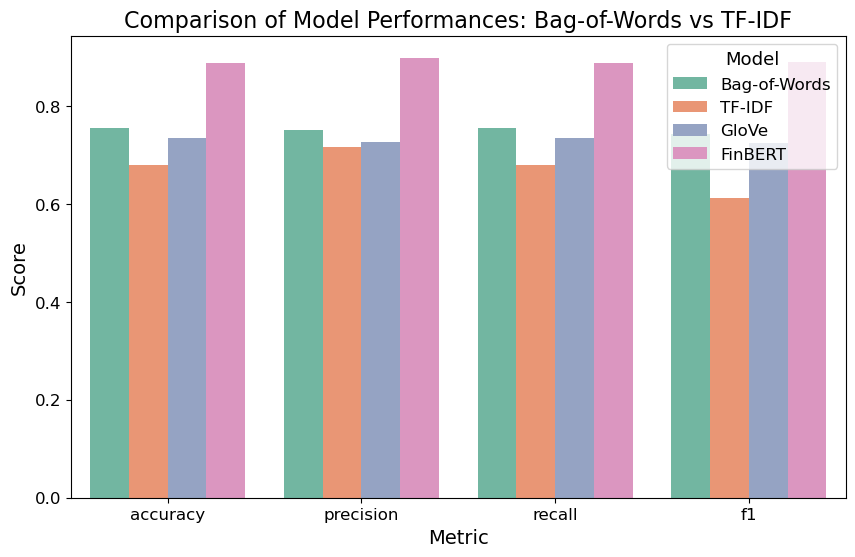

In [49]:
#
data = []
for metric in metrics_bow.keys():
    data.append({'Model': 'Bag-of-Words', 'Metric': metric, 'Score': metrics_bow[metric]})
    data.append({'Model': 'TF-IDF', 'Metric': metric, 'Score': metrics_tfidf[metric]})
    data.append({'Model': 'GloVe', 'Metric': metric, 'Score': metrics_glove[metric]})
    data.append({'Model': 'FinBERT', 'Metric': metric, 'Score': metrics_finbert[metric]})


metrics = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics , palette= 'Set2')

# Add labels and title
plt.title('Comparison of Model Performances: Bag-of-Words vs TF-IDF', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', title_fontsize='13', fontsize='12')

# Show the plot
plt.show()
